# "Road to recovery"

Simulation of various control measures under the asumption of remaining exposed (infected but not infectious) within the community.Arbitrayr epidemic parameters are presumed and then model with different network structures which accurately reflect different levels of "work-from-home", restrictions on gatherings, and/or COVIDSafe adoption - *under the assumption of those arbitrary choces of epidemic parameters*.

First, load some libraries....

In [1]:
cd("/Users/michael/work/GitHub/epinets")

In [2]:
include("EpiSim.jl")

Main.EpiSim

In [3]:
using CSV
using Plots
using LightGraphs
using JLD2, FileIO
using Statistics

Population of WA

In [4]:
pops=[426709 8089526 245869 5095100 1751693 534281 6594804 2621680]
pop=pops[8]

2621680

## Parameter guesstimates. 

Note, unlike previous simulations we only care about one choice of each parameter - there is no changepoint here.

In [28]:
#'reasonable' parameters
epiparam=Dict()
epiparam["p0"]=1/10 #a guess - tuned to match observed data 
epiparam["q"]=1/8 #"up to" two weeks
epiparam["r0"]=1/6 #about two weeks for mild, 3-6 for severe
epiparam["nseeds"]=5 #probably too many, consider dropping.
#parameters don't change across transition point - assume about 5 undiagnosed case 
#and control the covidsafe uptake via network structure
i=8
epiparam["pop"]=Int(floor(sqrt(pops[i])))^2
epiparam["gridsize"]=Int(floor(sqrt(pops[i])))

1619

## Build sample contact networks


Build contact networks with no restrictions and mass gatherings (bamodel), purely local (lattice), some level of work-from-home (wattsrog), or random mixing but no mass gatherings (randomgraph)

In [6]:
gridsize=epiparam["gridsize"]
bamodel=barabasi_albert(gridsize^2, 3, 2)
lattice=LightGraphs.grid((gridsize,gridsize),periodic=true)
#"social distancing"
wattstrog95=watts_strogatz(gridsize^2, 4, 0.013)  #s=0.013 => 95% compliance
wattstrog90=watts_strogatz(gridsize^2, 4, 0.026)  #s=0.026 => 90% compliance
wattstrog80=watts_strogatz(gridsize^2, 4, 0.053)  #s=0.053 => 80% compliance
wattstrog60=watts_strogatz(gridsize^2, 4, 0.120)  #s=0.120 => 60% compliance
wattstrog40=watts_strogatz(gridsize^2, 4, 0.205)  #s=0.205 => 40% compliance
wattstrog20=watts_strogatz(gridsize^2, 4, 0.332)  #s=0.332 => 20% compliance
randomgraph=watts_strogatz(gridsize^2, 4, 1)  #0% compliance

{2621161, 5242322} undirected simple Int64 graph

To simulate the effect of COVIDSafe, we remove links corresponding to the contacts that would be traced with the app. That is, if k is the fraction with the app, then we deletec k^2 edges from our graph.

In [7]:
#"covidsafe" at 40%
covidsafe=0.4
iso=covidsafe^2 #covidsafe implies removing iso fraction of all edges of graph
covidsafe40=deepcopy(randomgraph) 
for edg in edges(covidsafe40)
    if rand(Float64) .< iso
        rem_edge!(covidsafe40,edg)
    end
end
#there are two parameters to play with here - the underlying model (here bamodel, but it could be an ER graph, or a truncated
#scale free network, or a lattice - wattsrog - with a certain fraction of remote links) The second parameter is the level of covidsafe adoption
# of course the original transmission parameters could be changed too....

In [8]:
#"covidsafe" at 60%
covidsafe=0.6
iso=covidsafe^2 #covidsafe implies removing iso fraction of all edges of graph
covidsafe60=deepcopy(wattstrog40) 
for edg in edges(covidsafe60)
    if rand(Float64) .< iso
        rem_edge!(covidsafe60,edg)
    end
end
#40% work from home (wattstrog40 plus 60% COVIDSafe)

In [9]:
#"covidsafe" at 80%
covidsafe=0.8
iso=covidsafe^2 #covidsafe implies removing iso fraction of all edges of graph
covidsafe80=deepcopy(bamodel) 
for edg in edges(covidsafe80)
    if rand(Float64) .< iso
        rem_edge!(covidsafe80,edg)
    end
end
#40% work from home (wattstrog40 plus 60% COVIDSafe)

To simulate restrictions on mass gatherings, we take the BA model and delete edges from high degree nodes

In [10]:
#No more than 50 people
gather=50
gathering50=deepcopy(bamodel)
for nds in vertices(gathering50)
    neigh=neighbors(gathering50,nds)
    while length(neigh)>gather
        rem_edge!(gathering50,nds,rand(neigh))
        neigh=neighbors(gathering50,nds) 
    end
end

In [11]:
#combined: "covidsafe" at 50% - and no more than 50 people.
covidsafe=0.5
iso=covidsafe^2 #covidsafe implies removing iso fraction of all edges of graph
covidsafe50=deepcopy(gathering50) 
for edg in edges(covidsafe50)
    if rand(Float64) .< iso
        rem_edge!(covidsafe50,edg)
    end
end

## Simulations

Now we run a bunch of simualtions with these presumed control parameters and the network contact graphs generated above

In [ ]:
ndays=150#120 days, 100 simulations
nsims=100
St0,Et0,It0,Rt0=EpiSim.episim(bamodel, epiparam, ndays, nsims)   #no-limits - back to ther footy
St1,Et1,It1,Rt1=EpiSim.episim(covidsafe80, epiparam, ndays, nsims) #COVIDSafe at 80%, no other restrictions
St2,Et2,It2,Rt2=EpiSim.episim(randomgraph, epiparam, ndays, nsims) #no mass gatherings
St3,Et3,It3,Rt3=EpiSim.episim(covidsafe40, epiparam, ndays, nsims) #no mass gatherings, and 40% COVIDSafe
St4,Et4,It4,Rt4=EpiSim.episim(wattstrog40, epiparam, ndays, nsims) #40% social isolation
St5,Et5,It5,Rt5=EpiSim.episim(covidsafe60, epiparam, ndays, nsims) #40% social isolation & 60% COVIDSafe
St6,Et6,It6,Rt6=EpiSim.episim(gathering50, epiparam, ndays, nsims) #no more than 50 people
St7,Et7,It7,Rt7=EpiSim.episim(covidsafe50, epiparam, ndays, nsims) #no more than 50 people, COVIDSafe at 50%

0.0%┣                                          ┫ 0/100 [00:00<00:-5, -20.0 it/s]

## Plot

In [24]:
compl=0.2
swtch=1-compl^(1/4)
plotly()

┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots /Users/michael/.julia/packages/Plots/cc8wh/src/backends.jl:363


Plots.PlotlyBackend()

In [27]:
pop=epiparam["pop"]
plot([],title="Total anticipated infections",xlabel="day",ylabel="Infections",ylimit=(0,500),label=false,size=(1600,800))
EpiSim.plotquantiles(pop .- St0,:black,"Back to the footy",0.25)
EpiSim.plotquantiles(pop .- St1,:red,"Footy & 80% COVIDSafe",0.25)
EpiSim.plotquantiles(pop .- St6,:purple,"50 person limit",0.25)
EpiSim.plotquantiles(pop .- St7,:magenta,"50 person limit & 50% COVIDSafe",0.25)
EpiSim.plotquantiles(pop .- St2,:yellow,"No mass gatherings",0.25)
EpiSim.plotquantiles(pop .- St3,:orange,"40% COVIDSafe",0.25)
EpiSim.plotquantiles(pop .- St4,:blue,"40% Work-from-home",0.25)
EpiSim.plotquantiles(pop .- St5,:green,"40% Work-from-home & 60% COVIDSafe",0.25)

<!DOCTYPE html>
 
 
 Plots.jl

One I prepared earlier ...  with p=1/10, r=16.

In [87]:
plot([],title="Total anticipated infections",xlabel="day",ylabel="Infections",ylimit=(0,5000),label=false,size=(1200,800))
EpiSim.plotquantiles(pop .- St0,:black,"Back to the footy",0.25)
EpiSim.plotquantiles(pop .- St1,:red,"Footy & 80% COVIDSafe",0.25)
EpiSim.plotquantiles(pop .- St2,:yellow,"No mass gatherings",0.25)
EpiSim.plotquantiles(pop .- St3,:orange,"40% COVIDSafe",0.25)
EpiSim.plotquantiles(pop .- St4,:blue,"40% Work-from-home",0.25)
EpiSim.plotquantiles(pop .- St5,:green,"40% Work-from-home & 60% COVIDSafe",0.25)

<!DOCTYPE html>
 
 
 Plots.jl

One I prepared earlier ...  with p=1/6, r=16.

In [84]:
plot([],title="Total anticipated infections",xlabel="day",ylabel="Infections",ylimit=(0,5000),label=false,size=(1200,800))
EpiSim.plotquantiles(pop .- St0,:black,"Back to the footy",0.25)
EpiSim.plotquantiles(pop .- St1,:red,"Footy & 80% COVIDSafe",0.25)
EpiSim.plotquantiles(pop .- St2,:yellow,"No mass gatherings",0.25)
EpiSim.plotquantiles(pop .- St3,:orange,"40% COVIDSafe",0.25)
EpiSim.plotquantiles(pop .- St4,:blue,"40% Work-from-home",0.25)
EpiSim.plotquantiles(pop .- St5,:green,"40% Work-from-home & 60% COVIDSafe",0.25)

<!DOCTYPE html>
 
 
 Plots.jl

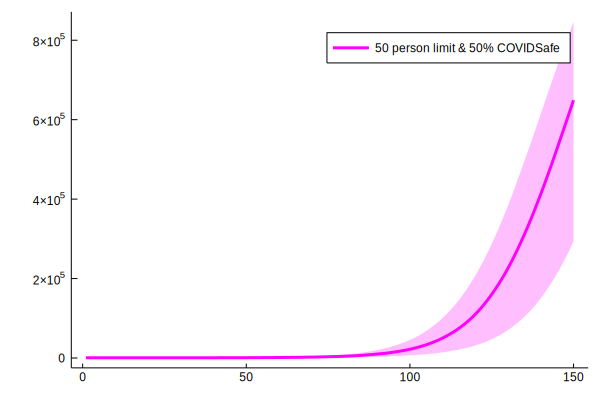

In [15]:
plot()
EpiSim.plotquantiles(pop .- St7,:magenta,"50 person limit & 50% COVIDSafe",0.25)